In [173]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    return a, b


def household_guess(a_grid,e_grid,r,w,gamma):
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis]
    V_prime = (1+r)*(wel/5)**(-gamma)
    return V_prime

def consumption(c,we,rest,gamma,v,phi):
    return c - we*(we/(phi*c**gamma))**(1/v) - rest


In [174]:
def household(V_prime_p,a_grid,e_grid,r,w,beta,gamma,v,phi):

    we = w*e_grid

    c_prime = (beta*V_prime_p)**(-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t
    n_prime = (we[:,np.newaxis]/(phi*c_prime**gamma))**(1/v)

    new_grid = c_prime + a_grid[np.newaxis,:] - we[:,np.newaxis]
    wel = (1+r)*a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + we[:,np.newaxis]*n - c
    V_prime= (1+r)*c**(-gamma)

    # checks for violations of the condition of minimal assets required and fixes it

    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

        aa = np.zeros((indexes_asset[0].size)) + 1E-5
        rest = -a_grid[0] + wel[indexes_asset[1]]
        bb = c[indexes_asset]
        
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)[1]
        n[indexes_asset] = (we[indexes_asset[0]]/(phi*c[indexes_asset]**gamma))**(1/v)
        V_prime[indexes_asset] = (1+r)*(c[indexes_asset])**(-gamma)

    return V_prime,a,c,n

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<function household at 0x7fbad605e3b0>


AttributeError: 'function' object has no attribute 'inputs'

In [175]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

In [176]:
e_grid, Pi, a_grid, pi_e = make_grid(0.9,1,2,0,100,200)
r = 0.01
w = 1
gamma = 1
beta = 0.99
v = 1
phi = 1.5

In [5]:
hh_start = household_guess(a_grid,e_grid,r,w,gamma)
household(hh_start,a_grid,e_grid,r,w,beta,gamma,v,phi)

(array([[12.66621218, 12.46338614, 12.26104438, 12.05927657, 11.8581714 ,
         11.65781633, 11.45829752, 11.25969967, 11.06210583, 10.86559734,
         10.67025364, 10.47615223, 10.28336845, 10.09197547,  9.90204414,
          9.71364294,  9.52683785,  9.34169231,  9.15826714,  8.9766205 ,
          8.79680783,  8.61888181,  8.44289232,  8.26888642,  8.09690835,
          7.9269995 ,  7.75919841,  7.5935408 ,  7.43005955,  7.26878473,
          7.10974364,  6.95296083,  6.79845814,  6.64625473,  6.49636715,
          6.34880938,  6.20359289,  6.0607267 ,  5.92021743,  5.7820694 ,
          5.64628467,  5.51286313,  5.38180255,  5.25309869,  5.12674536,
          5.00273451,  4.88105627,  4.7616991 ,  4.6446498 ,  4.52989365,
          4.41741443,  4.30719456,  4.19921513,  4.09345603,  3.98989595,
          3.88851255,  3.78928246,  3.69218139,  3.59718418,  3.50426488,
          3.41339685,  3.32455276,  3.2377047 ,  3.15282422,  3.06988243,
          2.98884999,  2.90969722,  2.

In [6]:
wel = (1+r)*a_grid
rest = -a_grid[0] + wel
rest.shape

(200,)

In [209]:
e_grid, Pi, a_grid, pi_e = make_grid(0.9,1,2,0,100,200)
r = 0.01
w = 1
gamma = 1
beta = 1/(1+r)
v = 1
phi = 1.5

In [210]:
V_prime_p = household_guess(a_grid,e_grid,r,w,gamma)

In [226]:
V_prime_p, _, _, _ = household(V_prime_p,a_grid,e_grid,r,w,beta,gamma,v,phi)

In [227]:
w = 0.5

we = w*e_grid

c_prime = (beta*V_prime_p)**(-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t
n_prime = (we[:,np.newaxis]/(phi*c_prime**gamma))**(1/v)

new_grid = c_prime + a_grid[np.newaxis,:] - we[:,np.newaxis]
wel = (1+r)*a_grid

c = interpolate.interpolate_y(new_grid,wel,c_prime)
n = interpolate.interpolate_y(new_grid,wel,n_prime)

a = wel + we[:,np.newaxis]*n - c
V_prime= (1+r)*c**(-gamma)

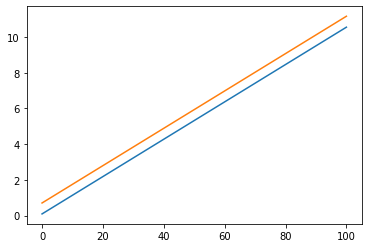

In [228]:
plt.plot(a_grid,c.T)
c_temp = np.copy(c)

In [229]:
indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
a[indexes_asset] = a_grid[0]

In [230]:
indexes_asset

(array([], dtype=int64), array([], dtype=int64))

In [147]:
if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

    aa = np.zeros((indexes_asset[0].size)) + 1E-5
    rest = -a_grid[0] + wel[indexes_asset[1]]
    bb = c[indexes_asset]
        
    c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)[1]
    n[indexes_asset] = (we[indexes_asset[0]]/(phi*c[indexes_asset]**gamma))**(1/v)
    V_prime[indexes_asset] = (1+r)*(c[indexes_asset])**(-gamma)


In [148]:
f_a = consumption(aa,we[indexes_asset[0]],rest,gamma,v,phi)
f_b = consumption(bb,we[indexes_asset[0]],rest,gamma,v,phi)

np.all(f_a*f_b <= 0)

True

In [154]:
f_b

array([1.49884272e-12, 1.25771789e-12, 1.02215458e-12, 1.29795480e-12,
       1.95572725e-13, 1.03572706e-12, 5.83322453e-12, 2.52012300e-12,
       4.23289875e-12, 4.58224431e-12, 1.08185474e-11, 3.46917634e-12,
       2.50975629e-12, 4.24819901e-12, 7.91088028e-12, 8.81253404e-12,
       1.07987230e-11, 5.99637007e-12, 1.07318321e-12, 4.01415012e-12,
       8.82577345e-12, 1.05175590e-11, 4.85630980e-12, 7.27987115e-12,
       6.69883593e-12, 1.58706381e-12, 4.91537366e-12, 6.65964506e-12,
       1.03456133e-11, 3.78053144e-12, 2.49250620e-12])

In [149]:
mid_point = (aa+bb)/2
f_mid = consumption(mid_point,we[indexes_asset[0]],rest,gamma,v,phi)

indxs_a = np.nonzero(f_mid*f_a <= 0)
indxs_b = np.nonzero(f_mid*f_b <= 0)

In [150]:
indxs_a

(array([ 0,  1,  2,  3,  6, 10, 14, 15, 16, 17, 20, 21, 23, 24, 27, 28]),)

In [151]:
indxs_b

(array([ 4,  5,  7,  8,  9, 11, 12, 13, 18, 19, 22, 25, 26, 29, 30]),)

In [152]:
new_a = aa
new_b = bb

if indxs_a[0].size != 0:
    new_a[indxs_a] = mid_point[indxs_a]
if indxs_b[0].size != 0:
    new_b[indxs_b] = mid_point[indxs_b]

In [304]:
V_prime_p = V_prime

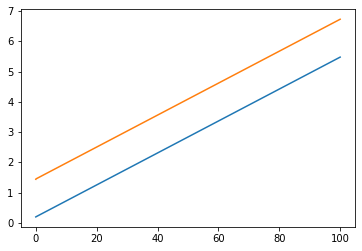

In [337]:
plt.plot(a_grid,c.T)

In [297]:
c - c_temp

array([[-0.00752561, -0.00633194, -0.00496881, -0.00345509, -0.00167578,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [307]:
vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)[0]

array([0.09732878, 0.10126586, 0.10548311, 0.10999777, 0.1148271 ,
       0.7191678 , 0.72303871, 0.72704968, 0.73120632, 0.73551451,
       0.7399804 , 0.74461041, 0.74941125, 0.75438994, 0.75955381,
       0.76491054, 0.77046815, 0.77623503, 0.78221995, 0.78843209,
       0.79488103, 0.80157683, 0.80852996, 0.8157514 , 0.82325262,
       0.83104561, 0.83914292, 0.84755764, 0.85630346, 0.86539469,
       0.87484627])

In [156]:
f_a = consumption(aa,we[indexes_asset[0]],rest,gamma,v,phi)
f_b = consumption(bb,we[indexes_asset[0]],rest,gamma,v,phi)
middle = (aa+bb)/2
f_mid = consumption(middle,we[indexes_asset[0]],rest,gamma,v,phi)
np.nonzero(f_mid*f_a <= 0)[0].size

37

In [115]:
bb.shape

(67,)

In [120]:
consumption(aa,we[indexes_asset[0]],rest,gamma,v,phi)

array([  -947.28909791,   -947.29681901,   -947.30477621,   -947.31297673,
         -947.32142801,   -947.33013772,   -947.33911377,   -947.34836428,
         -947.35789767,   -947.36772257,   -947.37784791,   -947.38828286,
         -947.3990369 ,   -947.41011978, -51720.23282829, -51720.24054939,
       -51720.24850659, -51720.25670712, -51720.2651584 , -51720.27386811,
       -51720.28284415, -51720.29209467, -51720.30162805, -51720.31145296,
       -51720.32157829, -51720.33201324, -51720.34276728, -51720.35385017,
       -51720.36527195, -51720.37704299, -51720.38917398, -51720.40167592,
       -51720.41456014, -51720.42783835, -51720.44152259, -51720.45562528,
       -51720.4701592 , -51720.48513755, -51720.50057392, -51720.51648232,
       -51720.53287716, -51720.54977335, -51720.56718619, -51720.58513149,
       -51720.60362554, -51720.62268511, -51720.64232749, -51720.66257051,
       -51720.68343253, -51720.70493249, -51720.72708988, -51720.74992482,
       -51720.77345802, -

In [121]:
consumption(bb,we[indexes_asset[0]],rest,gamma,v,phi)

array([0.08553319, 0.08058872, 0.07547108, 0.07017452, 0.06469313,
       0.0590208 , 0.05315126, 0.04707806, 0.04079456, 0.0342939 ,
       0.02756906, 0.02061279, 0.01341765, 0.00597596, 0.63200951,
       0.62707434, 0.62198519, 0.61673717, 0.61132524, 0.6057442 ,
       0.59998867, 0.59405311, 0.58793178, 0.58161877, 0.57510797,
       0.56839307, 0.56146757, 0.55432472, 0.54695758, 0.53935899,
       0.53152152, 0.52343752, 0.51509909, 0.50649807, 0.49762602,
       0.48847424, 0.47903372, 0.46929518, 0.45924903, 0.44888534,
       0.43819388, 0.42716407, 0.41578499, 0.40404536, 0.39193352,
       0.37943744, 0.36654467, 0.35324238, 0.33951729, 0.32535572,
       0.31074349, 0.295666  , 0.28010815, 0.26405434, 0.24748846,
       0.2303939 , 0.21275346, 0.19454941, 0.17576343, 0.15637661,
       0.13636941, 0.11572166, 0.09441253, 0.07242053, 0.04972345,
       0.02629838, 0.00212165])

In [92]:
bb

array([0.16398454, 0.16613435, 0.16834989, 0.17063318, 0.17298629,
       0.17541135, 0.17791057, 0.18048622, 0.18314062, 0.18587619,
       0.18869541, 0.19160084, 0.19459511, 0.19768094, 1.211691  ,
       1.2138408 , 1.21605634, 1.21833963, 1.22069274, 1.22311781,
       1.22561703, 1.22819267, 1.23084707, 1.23358264, 1.23640186,
       1.23930729, 1.24230156, 1.2453874 , 1.24856759, 1.25184503,
       1.25522269, 1.25870363, 1.26229101, 1.2659881 , 1.26979823,
       1.27372487, 1.27777159, 1.28194204, 1.28624003, 1.29066944,
       1.29523429, 1.29993874, 1.30478703, 1.30978359, 1.31493293,
       1.32023973, 1.3257088 , 1.33134511, 1.33715377, 1.34314005,
       1.34930939, 1.35566737, 1.36221977, 1.36897254, 1.3759318 ,
       1.38310386, 1.39049523, 1.39811262, 1.40596294, 1.41405331,
       1.42239107, 1.43098379, 1.43983927, 1.44896553, 1.45837086,
       1.46806379, 1.47805312])

In [167]:
def f(x,c): return x**2 -2*x - c

In [169]:
a,b = vec_bissection(lambda x : f(x,np.array([1.5,2.0,5.0])),np.array([0.0,0,0]),np.array([3.0,3,6]))

In [172]:
f(b,np.array([1.5,2.0,5.0]))

array([6.59294841e-12, 6.56363852e-13, 1.71649361e-11])